In [1]:
print("HI")

HI


### Build A Basic Chatbot with LangGraph(Graph API)

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [3]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list,add_messages]

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama-3.1-8b-instant")

In [6]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x115b4cf10>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x115be19d0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
## Node Functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [8]:
graph_builder=StateGraph(State)

## Adding node
graph_builder.add_node("llmchatbot",chatbot)
## Adding Edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

## compile the graph
graph=graph_builder.compile()

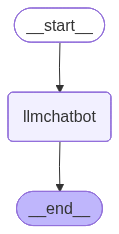

In [9]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [10]:
response=graph.invoke({"messages":"Hi"})

In [11]:
response["messages"][-1].content

"It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [12]:
for event in graph.stream({"messages":"Hi How are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)

I'm doing well, thank you for asking. I'm a large language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help with any questions or tasks you may have. How about you? How's your day going so far?


### Chatbot With Tool

In [13]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("What is langgraph")

{'query': 'What is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interaction

In [ ]:
## Custom function
# For custom funtion, it should be invoked with doc string! helps llm to understand the use of function
# It should have i/p and args
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [15]:
tools=[tool,multiply]

In [16]:
llm_with_tool=llm.bind_tools(tools)

In [17]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x115b4cf10>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x115be19d0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of domai

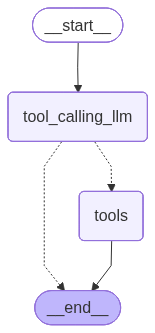

In [18]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
response=graph.invoke({"messages":"What is the recent ai news"})

In [20]:
response['messages'][-1].content

'{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.manufacturing.net/artificial-intelligence/news/22954247/survey-reveals-manufacturing-businesses-struggle-with-genai-skills-gap", "title": "Survey Reveals Manufacturing Businesses Struggle with GenAI Skills Gap - Manufacturing.net", "score": 0.7429634, "published_date": "Wed, 05 Nov 2025 00:00:00 GMT", "content": "Latest in Artificial Intelligence\\n\\nSponsored\\n\\n##### Industrial Media Unboxing Video\\n\\nNovember 3, 2025\\n\\n##### Mimic Robotics Raises $16M For Physical AI\\n\\nNovember 5, 2025\\n\\n##### The AI Productivity Cycle: Revolutionizing Manufacturing Through Connected Intelligence\\n\\nNovember 4, 2025\\n\\n##### Amazon, OpenAI Sign $38B Deal for AI Computing Power\\n\\nNovember 4, 2025\\n\\nRelated Stories\\n\\nArtificial Intelligence\\n\\n##### Mimic Robotics Raises $16M For Physical AI\\n\\nArtificial Intelligence [...] ##### The AI Productivity Cy

In [21]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (sb72k8tdf)
 Call ID: sb72k8tdf
  Args:
    query: recent ai news
    search_depth: advanced
    time_range: week
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.manufacturing.net/artificial-intelligence/news/22954247/survey-reveals-manufacturing-businesses-struggle-with-genai-skills-gap", "title": "Survey Reveals Manufacturing Businesses Struggle with GenAI Skills Gap - Manufacturing.net", "score": 0.7429634, "published_date": "Wed, 05 Nov 2025 00:00:00 GMT", "content": "Latest in Artificial Intelligence\n\nSponsored\n\n##### Industrial Media Unboxing Video\n\nNovember 3, 2025\n\n####

In [22]:
response=graph.invoke({"messages":"What is 5 multiplied by 2"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 multiplied by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (6dxgzjad9)
 Call ID: 6dxgzjad9
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10


In [23]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (4k0st3fx2)
 Call ID: 4k0st3fx2
  Args:
    query: Recent AI news
    search_depth: advanced
    time_range: day
    topic: news
  multiply (vbbm05z91)
 Call ID: vbbm05z91
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "Recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.businessinsider.com/ai-tools-used-most-by-companies-chatgpt-claude-copilot-gemini-2025-11", "title": "The AI tools used most by companies. There's a surprising winner and a shocking laggard. - Business Insider", "score": 0.6551821, "published_date": "Fri, 07 Nov 2025 18:29:50 GMT", "content": "A version of this story originally appea

The above architecture, only gave the out individually, The reasoning is not there. 
Solution is ReAct Arch

### ReAct Architecture

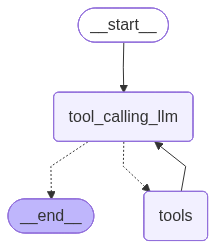

In [24]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
response=graph.invoke({"messages":"What is Ai Engineer and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is Ai Engineer and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (s5b3yrwbf)
 Call ID: s5b3yrwbf
  Args:
    include_domains: ['wikipedia.org']
    query: What is an AI Engineer
  multiply (sej3kjtt8)
 Call ID: sej3kjtt8
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "What is an AI Engineer", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/Category:Artificial_intelligence_engineering", "title": "Category:Artificial intelligence engineering", "content": "Artificial Intelligence (AI) engineering is the interdisciplinary field focused on designing, developing, and deploying AI systems.", "score": 0.6836946, "raw_content": null}, {"url": "https://en.wikipedia.org/wiki/A

In [32]:
response["messages"][-1].content

"The response from the AI model is that an AI Engineer is responsible for designing, developing, and deploying AI systems. They must ensure that these systems are safe and adhere to legal frameworks, such as data protection regulations. AI Engineers also set up performance monitoring to detect issues like model drift, where the model's accuracy decreases over time as data patterns change."

### Adding Memory In Agentic Graph

In [33]:
response=graph.invoke({"messages":"Hello my name is Sumanth"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello my name is Sumanth
================================== Ai Message ==================================

Nice to meet you, Sumanth. How can I assist you today?


In [34]:
response=graph.invoke({"messages":"What is my name"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is my name
================================== Ai Message ==================================

I don't have any information about your name. I'm a large language model, I don't have the ability to store or recall information about individual users. Each time you interact with me, it's a new conversation and I don't retain any context from previous conversations. If you'd like to share your name with me, I can try to remember it for the duration of our conversation.


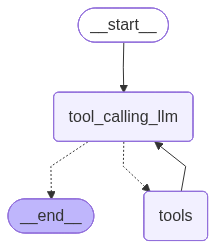

In [38]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

#An in-memory checkpoint saver.
#This checkpoint saver stores checkpoints in memory using a defaultdict.
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [39]:
config={"configurable":{"thread_id":"1"}}

response=graph.invoke({"messages":"Hi my name is Sumanth"},config=config)

response

{'messages': [HumanMessage(content='Hi my name is Sumanth', additional_kwargs={}, response_metadata={}, id='32a62308-cc93-48c0-a257-7eff1b23fc85'),
  AIMessage(content='Nice to meet you, Sumanth. Is there anything I can help you with?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 1856, 'total_tokens': 1875, 'completion_time': 0.028385462, 'prompt_time': 0.122071723, 'queue_time': 0.035626467, 'total_time': 0.150457185}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_020e283281', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--fdbf2c36-91d7-4116-af6f-d869fd6cf344-0', usage_metadata={'input_tokens': 1856, 'output_tokens': 19, 'total_tokens': 1875})]}

In [40]:
response['messages'][-1].content

'Nice to meet you, Sumanth. Is there anything I can help you with?'

In [41]:
response=graph.invoke({"messages":"Hey what is my name"},config=config)

print(response['messages'][-1].content)

Sumanth


In [42]:
response=graph.invoke({"messages":"Hey do you remember my name"},config=config)

print(response['messages'][-1].content)

It looks like your name, Sumanth, has a rich meaning in Sanskrit, related to being good or auspicious.


### Streaming

In [43]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [44]:
def superbot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}

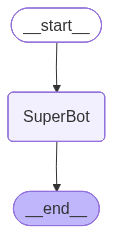

In [45]:
graph=StateGraph(State)

## node
graph.add_node("SuperBot",superbot)
## Edges

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)


graph_builder=graph.compile(checkpointer=memory)


## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [46]:
## Invocation

config = {"configurable": {"thread_id": "1"}}

graph_builder.invoke({'messages':"Hi,My name is Sumanth And I like cricket"},config)

{'messages': [HumanMessage(content='Hi,My name is Sumanth And I like cricket', additional_kwargs={}, response_metadata={}, id='1c449344-9443-4d61-8414-b3096474f90c'),
  AIMessage(content='Hello Sumanth, nice to meet you. Cricket is a fantastic sport, and many people around the world are passionate about it. Are you a fan of any particular team or player? Do you have a favorite format of the game, such as Test cricket, One-Day Internationals (ODIs), or Twenty20 (T20)?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 47, 'total_tokens': 117, 'completion_time': 0.085626624, 'prompt_time': 0.003217927, 'queue_time': 0.034756437, 'total_time': 0.088844551}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_020e283281', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--0795f4bf-9b67-486a-87d1-e2b5488a8845-0', usage_metadata={'input_tokens': 47, 'output_tokens': 70, 'total_tokens': 117})]}

### Streaming
Methods: .stream() and astream()

These methods are sync and async methods for streaming back results.
Additional parameters in streaming modes for graph state

values : This streams the full state of the graph after each node is called.

updates : This streams updates to the state of the graph after each node is called.

In [47]:
# Create a thread
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Sumanth And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Nice to meet you, Sumanth! I'm glad to hear that you like cricket. It's a wonderful sport with a huge following worldwide. Are you a fan of any particular team or player? Do you enjoy watching live matches or playing the game yourself?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 47, 'total_tokens': 101, 'completion_time': 0.079067091, 'prompt_time': 0.00236835, 'queue_time': 0.035974284, 'total_time': 0.081435441}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_020e283281', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--15816007-4e87-4476-9191-660e5e499b26-0', usage_metadata={'input_tokens': 47, 'output_tokens': 54, 'total_tokens': 101})]}}


We only see the latest message getting returned, when MODE=Updates

In [48]:
for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Sumanth And I like cricket', additional_kwargs={}, response_metadata={}, id='b0d98eae-0f27-4386-8eac-cb676e94acba'), AIMessage(content="Nice to meet you, Sumanth! I'm glad to hear that you like cricket. It's a wonderful sport with a huge following worldwide. Are you a fan of any particular team or player? Do you enjoy watching live matches or playing the game yourself?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 47, 'total_tokens': 101, 'completion_time': 0.079067091, 'prompt_time': 0.00236835, 'queue_time': 0.035974284, 'total_time': 0.081435441}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_020e283281', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--15816007-4e87-4476-9191-660e5e499b26-0', usage_metadata={'input_tokens': 47, 'output_tokens': 54, 'total_tokens': 101}), HumanMessage(content='Hi,My name is Krish And I like crick

This has the updated messages added/appended to the messages and gives you the whole journey

In [49]:
# Create a thread
config = {"configurable": {"thread_id": "4"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='Nice to meet you, Krish. Cricket is a fantastic sport. Which team or player is your favorite in international cricket?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 45, 'total_tokens': 70, 'completion_time': 0.035814571, 'prompt_time': 0.002857518, 'queue_time': 0.072495026, 'total_time': 0.038672089}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_31e1ee87c5', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--943de229-5c2f-4908-85e6-53332a87bd09-0', usage_metadata={'input_tokens': 45, 'output_tokens': 25, 'total_tokens': 70})]}}


In [50]:
for chunk in graph_builder.stream({'messages':"I also like football"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='ec77431a-2d12-4652-abb1-151ada81791e'), AIMessage(content='Nice to meet you, Krish. Cricket is a fantastic sport. Which team or player is your favorite in international cricket?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 45, 'total_tokens': 70, 'completion_time': 0.035814571, 'prompt_time': 0.002857518, 'queue_time': 0.072495026, 'total_time': 0.038672089}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_31e1ee87c5', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--943de229-5c2f-4908-85e6-53332a87bd09-0', usage_metadata={'input_tokens': 45, 'output_tokens': 25, 'total_tokens': 70}), HumanMessage(content='I also like football', additional_kwargs={}, response_metadata={}, id='56caf650-25c6-430d-a3ff-309406c82334')]}
{'messages': [HumanMessage(content='Hi,My na

In [51]:
for chunk in graph_builder.stream({'messages':"What sports do I like?"},config):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='You, Krish, like two sports: \n\n1. Cricket\n2. Football', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 149, 'total_tokens': 166, 'completion_time': 0.024567978, 'prompt_time': 0.008658331, 'queue_time': 0.07708111, 'total_time': 0.033226309}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4dea31877a', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--79ce1a42-a178-4c1d-9497-f1cc94d9c5c8-0', usage_metadata={'input_tokens': 149, 'output_tokens': 17, 'total_tokens': 166})]}}


In [52]:

config = {"configurable": {"thread_id": "5"}}

async for event in graph_builder.astream_events({"messages":["Hi My name is Krish and I like to play cricket"]},config,version="v2"):
    print(event)


{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi My name is Krish and I like to play cricket']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '342db545-806e-4e0f-bf3a-a1f27479ae4c', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi My name is Krish and I like to play cricket', additional_kwargs={}, response_metadata={}, id='11aa62d9-e029-4660-9995-b4e0f63c49b3')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': '79aa2d83-2143-4109-9c5c-8680db1db572', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:109b0337-e765-5ba7-3dd7-8e55a9a89747'}, 'parent_ids': ['342db545-806e-4e0f-bf3a-a1f27479ae4c']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi My name is Krish and I like to pla

### Human In the Loop

In [53]:
import os
from langchain.chat_models import init_chat_model
llm=init_chat_model("groq:llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x122231950>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x116dcaa50>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [54]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [56]:

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

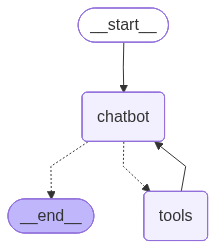

In [57]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [58]:

user_input = "I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (7y8b334ar)
 Call ID: 7y8b334ar
  Args:
    query: Request assistance from a human for building an AI agent.


In [61]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (tn1hmjhnm)
 Call ID: tn1hmjhnm
  Args:
    include_domains: ['langgraph.com']
    include_favicon: True
    include_images: True
    query: building a reliable and extensible AI agent with LangGraph
    search_depth: advanced
    topic: general
================================= Tool Message =================================
Name: tavily_search

No search results found for 'building a reliable and extensible AI agent with LangGraph'. Suggestions: Remove include_domains argument. Try modifying your search parameters with one of these approaches.
================================== Ai Message =========================